In [1]:
from jinja2 import Environment, FileSystemLoader
import os
import openai
import boto3
import json

def prompt_iterator(template: str):
  data_dir = './data'

  file_list = os.listdir(data_dir)
  file_list.sort(key=lambda x: int(x[1:x.index(".")]))

  for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)

    with open(file_path, 'r') as file:
      data = file.read()

    output = template.render(data=data)
    
    yield output

env = Environment(loader=FileSystemLoader('.'))
prompt_template = env.get_template('analysis_prompt.j2')

openai_client = openai.OpenAI()
def generate_openai_completion(prompt: str, test_case: int):
  response = openai_client.chat.completions.create(
    model="gpt-4-turbo-preview",
    messages=[
      {"role": "assistant", "content": prompt},
    ],
    temperature=0.3,
  )

  completion = response.choices[0].message.content
  with open(f"./gpt4/d{test_case}.txt", 'w') as file:
    file.write(completion)


bedrock_client = boto3.client('bedrock-runtime', region_name='us-east-1')
def generate_claude_completion(prompt: str, test_case: int):
  body = {
    "messages": [{ "role": "user", "content": [{ "type": "text", "text": prompt}]}],
    "anthropic_version": "bedrock-2023-05-31",
    "temperature": 0.3,
    "top_p": 1,
    "top_k": 50,
    "max_tokens": 4096,
    }
  
  response = bedrock_client.invoke_model(modelId="anthropic.claude-3-sonnet-20240229-v1:0", body=json.dumps(body))

  response_body = json.loads(response["body"].read())
  completion = response_body["content"][0]["text"]

  with open(f"./claude3/d{test_case}.txt", 'w') as file:
    file.write(completion)

In [2]:
for i, p in enumerate(prompt_iterator(prompt_template)):
    generate_claude_completion(p, i + 1)
    generate_openai_completion(p, i + 1)

KeyboardInterrupt: 

In [10]:
datasets = ["d3.txt", "d4.txt", "d9.txt"]
def graph_prompt_iterator(template: str):
  data_dir = './metadata'

  file_list = os.listdir(data_dir)
  file_list.sort(key=lambda x: int(x[1:x.index(".")]))
  file_list = [f for f in file_list if f in datasets]
  print(file_list)

  for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)

    with open(file_path, 'r') as file:
      table = file.read()

    output = template.render(table=table)
    
    yield output

openai_client = openai.OpenAI()
def generate_openai_graph_completion(prompt: str, test_case: int):
  response = openai_client.chat.completions.create(
    model="gpt-4-turbo-preview",
    messages=[
      {"role": "assistant", "content": prompt},
    ],
    temperature=0.3,
  )

  completion = response.choices[0].message.content
  with open(f"./gpt4/graphs/d{test_case}.txt", 'w') as file:
    file.write(completion)


bedrock_client = boto3.client('bedrock-runtime', region_name='us-east-1')
def generate_claude_graph_completion(prompt: str, test_case: int):
  body = {
    "messages": [{ "role": "user", "content": [{ "type": "text", "text": prompt}]}],
    "anthropic_version": "bedrock-2023-05-31",
    "temperature": 0.3,
    "top_p": 1,
    "top_k": 50,
    "max_tokens": 4096,
    }
  
  response = bedrock_client.invoke_model(modelId="anthropic.claude-3-sonnet-20240229-v1:0", body=json.dumps(body))

  response_body = json.loads(response["body"].read())
  completion = response_body["content"][0]["text"]

  with open(f"./claude3/graphs/d{test_case}.txt", 'w') as file:
    file.write(completion)

In [14]:

graph_prompt_template = env.get_template('generate_graph_prompt.j2')
for i, p in enumerate(graph_prompt_iterator(graph_prompt_template)):
    generate_openai_graph_completion(p, i + 1)
    generate_claude_graph_completion(p, i + 1)

['d3.txt', 'd4.txt', 'd9.txt']


In [ ]:
import csv
import json

def csv_to_json(csv_file, json_file):
    data = []
    
    with open(csv_file, 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            data.append(row)
    
    with open(json_file, 'w') as file:
        json.dump(data, file)


csv_to_json('data/d3.csv', 'data/d3.json')
csv_to_json('data/d4.csv', 'data/d4.json')
csv_to_json('data/d9.csv', 'data/d9.json')

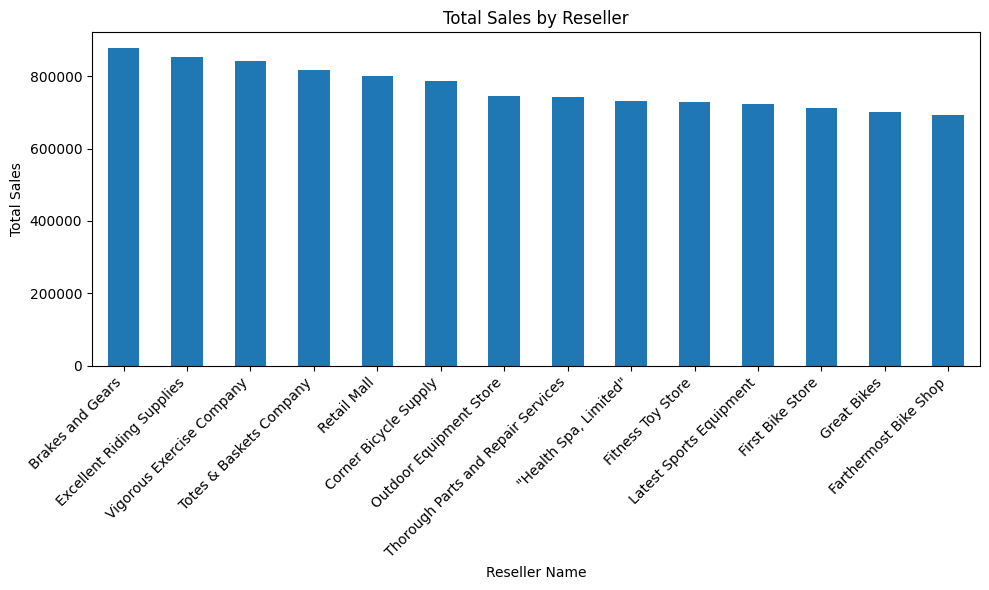

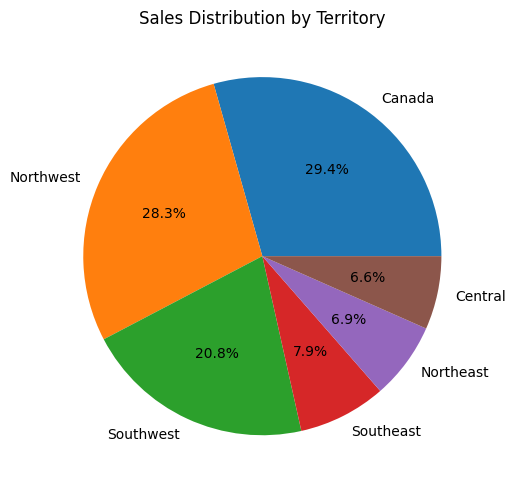

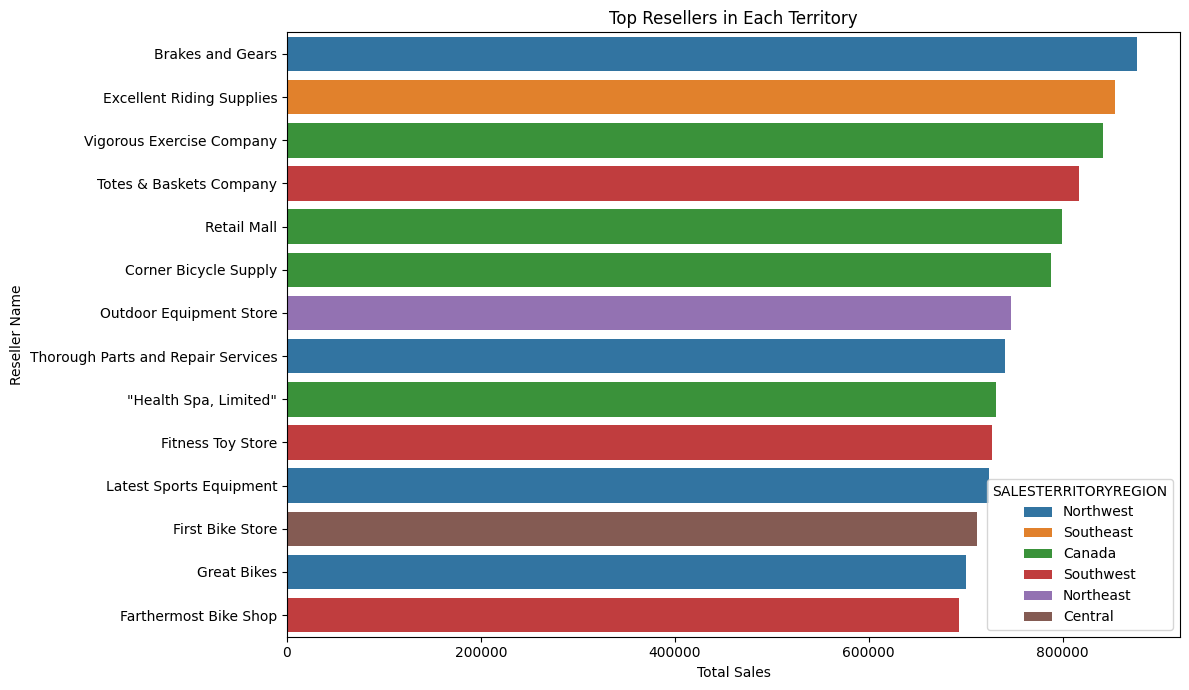

In [1]:
# Code generated by OpenAI

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = {
    'RESELLERNAME': ['Brakes and Gears', 'Excellent Riding Supplies', 'Vigorous Exercise Company', 
                     'Totes & Baskets Company', 'Retail Mall', 'Corner Bicycle Supply', 
                     'Outdoor Equipment Store', 'Thorough Parts and Repair Services', 
                     '"Health Spa, Limited"', 'Fitness Toy Store', 'Latest Sports Equipment', 
                     'First Bike Store', 'Great Bikes', 'Farthermost Bike Shop'],
    'SALESTERRITORYREGION': ['Northwest', 'Southeast', 'Canada', 'Southwest', 'Canada', 
                             'Canada', 'Northeast', 'Northwest', 'Canada', 'Southwest', 
                             'Northwest', 'Central', 'Northwest', 'Southwest'],
    'TOTAL_SALES': [877115, 853854, 841917, 816767, 799294, 787770, 746325, 740989, 
                    730804, 727282, 724296, 711873, 700803, 693512]
}

df = pd.DataFrame(data)

# Trend 1: Total Sales by Reseller
reseller_sales = df.groupby('RESELLERNAME')['TOTAL_SALES'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
reseller_sales.plot(kind='bar')
plt.title('Total Sales by Reseller')
plt.ylabel('Total Sales')
plt.xlabel('Reseller Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Trend 2: Sales Distribution by Territory
territory_sales = df.groupby('SALESTERRITORYREGION')['TOTAL_SALES'].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
territory_sales.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sales Distribution by Territory')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Trend 3: Top Resellers in Each Territory
plt.figure(figsize=(12, 7))
sns.barplot(x='TOTAL_SALES', y='RESELLERNAME', hue='SALESTERRITORYREGION', data=df.sort_values('TOTAL_SALES', ascending=False))
plt.title('Top Resellers in Each Territory')
plt.xlabel('Total Sales')
plt.ylabel('Reseller Name')
plt.tight_layout()
plt.show()

In [3]:
# Code generated by Claude
import csv

# Open the CSV file
with open('./data/d2.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)

# Insight 1: Average yearly income by gender
gender_income = {}
for row in data:
    gender = row['GENDER']
    income = int(row['YEARLYINCOME'])
    if gender in gender_income:
        gender_income[gender]['total'] += income
        gender_income[gender]['count'] += 1
    else:
        gender_income[gender] = {'total': income, 'count': 1}

for gender, stats in gender_income.items():
    avg_income = stats['total'] / stats['count']
    print(f"Average yearly income for {gender}: {avg_income:.2f}")

print("\n")

# Insight 2: Highest total revenue by occupation
occupation_revenue = {}
for row in data:
    occupation = row['OCCUPATION']
    revenue = int(row['TOTAL_REVENUE'])
    if occupation in occupation_revenue:
        occupation_revenue[occupation] += revenue
    else:
        occupation_revenue[occupation] = revenue

highest_revenue_occupation = max(occupation_revenue, key=occupation_revenue.get)
print(f"Occupation with the highest total revenue: {highest_revenue_occupation} ({occupation_revenue[highest_revenue_occupation]})")

print("\n")

# Insight 3: Correlation between education level and yearly income
education_income = {}
for row in data:
    education = row['EDUCATION']
    income = int(row['YEARLYINCOME'])
    if education in education_income:
        education_income[education].append(income)
    else:
        education_income[education] = [income]

for education, incomes in education_income.items():
    avg_income = sum(incomes) / len(incomes)
    print(f"Average yearly income for {education}: {avg_income:.2f}")

Average yearly income for F: 79271.52
Average yearly income for M: 80828.03


Occupation with the highest total revenue: Professional (9848197)


Average yearly income for Bachelors: 73880.60
Average yearly income for Partial College: 84461.54
Average yearly income for Graduate Degree: 74666.67
Average yearly income for High School: 83333.33
Average yearly income for Partial High School: 84800.00
